# Modular Visualization Toolkit for Weather Analogue Analysis

This notebook includes a comprehensive visualization toolkit for analyzing weather analogue data. The toolkit provides:

1. **Modular plotting functions** - Easy-to-use functions for creating various visualizations
2. **Flexible customization** - Configurable parameters for colors, sizes, styles, and content
3. **Consistent styling** - Unified appearance across different plot types
4. **Reusable components** - Methods that can be called with different datasets and parameters


# Weather Analogue First Phase Validation - Single Event Analysis

This notebook analyzes the performance of different weather analogue search methods for a single event. The analysis includes:

1. **Residual Analysis**: Comparing Sum of Squared Residuals (SSR) for different variables across analogue methods
2. **Rank Histogram Analysis**: Evaluating the reliability of ensemble forecasts
3. **Spread-Skill Relationship**: Examining the relationship between ensemble spread and RMSE
4. **Precipitation Analysis**: Specialized analysis for precipitation data

The notebook compares multiple analogue search methods including AtmoDist, AtmoDist-SW (spatially weighted), and traditional methods like Euclidean, Cosine, and SSIM.

In [1]:
"""
Single Event Validation for Weather Analogue Methods

This notebook compares different weather analogue search methods for a single event,
focusing on their ability to find similar weather patterns.

Author: Yu Han
Date: June 2025
"""

# Standard library imports
import copy
import datetime
import json
import os
import random
import sys
from collections import defaultdict

# Data processing imports
import numpy as np
import pandas as pd
import xarray as xr
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import linregress
from skimage.metrics import structural_similarity as ssim

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.dates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


In [2]:
# Configure working directory and import custom modules
try:
    os.chdir("../")
except:
    pass

current_directory = os.getcwd()
print(f"Working directory: {current_directory}")
sys.path.append(os.path.abspath(os.path.join(current_directory, "notebooks")))

# Import custom utility functions
from utils.utils import set_working_directory, load_json_config
from utils.utils_data import read_netcdf
from utils.utils_parsers import batch_data_parser, model_parser, feature_map_parser
from utils.utils_analog import (
    generate_time_weights, cosine_similarity, euclidean_similarity, 
    ssim_similarity, search_analogs, revise_analogs, 
    attach_data_to_analogs, plot_analogs, plot_analogs_with_band
)

# Set seeds for reproducibility
seed = 11
random.seed(seed)
np.random.seed(seed)

Working directory: /home/yuhan/Desktop/Master/yu-ml-weather-analogue


## Process Data


### - Load ERA5 Data

In [3]:
# Define data parameters
variable_list = ["d2m", "u", "v", "msl", "r"]  # Meteorological variables to analyze
variables = ''.join(variable_list)
selected_frequency = 1
time_unit = "h"
resample_method = "none"
preprocessing_method = "raw"
year_range = (2004, 2020)

# Construct file paths for data files
all_variables_data_path = f"../data/processed/{variables}_{selected_frequency}{time_unit}_{resample_method}_{preprocessing_method}_{year_range[0]}{year_range[1]}.h5"
all_variables_standardized_data_path = f"../data/processed/{variables}_{selected_frequency}{time_unit}_{resample_method}_standardized_{year_range[0]}{year_range[1]}.h5"
all_variables_normalized_data_path = f"../data/processed/{variables}_{selected_frequency}{time_unit}_{resample_method}_normalized_{year_range[0]}{year_range[1]}.h5"
prep_path = f"../data/processed/tp_{selected_frequency}{time_unit}_{resample_method}_{preprocessing_method}_{year_range[0]}{year_range[1]}.h5"

# Load meteorological variable data
print(f"Loading data from: {all_variables_data_path}")
all_variables_data = read_netcdf(all_variables_data_path)

# Load precipitation data
print(f"Loading precipitation data from: {prep_path}")
prep_data = read_netcdf(prep_path)

Loading data from: ../data/processed/d2muvmslr_1h_none_raw_20042020.h5
Loading precipitation data from: ../data/processed/tp_1h_none_raw_20042020.h5


### - Load Events

In [4]:
# Load flood events data
events_df = pd.read_csv("data/raw/events_flood.csv")
events_df = events_df.sort_values(by="start datetime")  # Sort by start datetime in ascending order
events_df["start datetime"] = pd.to_datetime(events_df["start datetime"])
events_df["end datetime"] = pd.to_datetime(events_df["end datetime"])
print(f"Loaded {len(events_df)} flood events")

# Load spatial grid weights
weights_path = 'data/raw/weights.json'
print(f"Loading grid weights from: {weights_path}")
with open(weights_path, 'r') as f:
    loaded_data = json.load(f)

grid_weights = np.array(loaded_data['grid_weights'])

# Define weight threshold for significance
threshold = 0.0030  # Minimum weight value to consider for analysis

# Find indices of grid points with weights above threshold
flattened_grid_weights = grid_weights.ravel()
indices_above_threshold = np.where(flattened_grid_weights > threshold)[0]
local_indices_list = indices_above_threshold.tolist()

# Specify index for focused analysis (row 16, column 14 in a 32x32 grid)
specified_index = 16*32+14
print(f"Specified index: {specified_index}")
print(f"Number of grid points above threshold: {len(local_indices_list)}")


Loaded 157 flood events
Loading grid weights from: data/raw/weights.json
Specified index: 526
Number of grid points above threshold: 34


### - Aggregate analogue with data


In [5]:
# Define parameters for analogs analysis
project = "first_stage"  # Project name
similarity_method = "weighted_similarity"  # Method used for finding analogs
event_index = 24  # Index of the event to analyze

# Construct file path and load analogs data
directory = f'../data/analogs/{project}'
file_path = f'{directory}/{similarity_method}.json'
print(f"Reading analogs from: {file_path}")

with open(file_path, 'r') as f:
    all_results = json.load(f)

# Extract analogs for the specified event
analogs_single_event = all_results[event_index]
print(f"Analyzing event {event_index} with {len(analogs_single_event)} analogs")

# Attach meteorological data to analogs
analogue_results_with_data = attach_data_to_analogs(
    all_variables_data,
    analogs_single_event
)
print(f"Data attached to analogs successfully")

Reading analogs from: ../data/analogs/first_stage/weighted_similarity.json
Analyzing event 24 with 8 analogs
Data attached to analogs successfully


### -Variance for seperate variables

Channel 1: d2m
  Plotting n=1, plot_count=1
  Plotting n=4, plot_count=2
  Plotting n=7, plot_count=3
  Plotting n=2, plot_count=4
  Plotting n=5, plot_count=5
  Plotting n=3, plot_count=6
  Plotting n=6, plot_count=7
Channel 2: u
  Plotting n=1, plot_count=1
  Plotting n=7, plot_count=2
  Plotting n=3, plot_count=3
  Plotting n=6, plot_count=4
  Plotting n=4, plot_count=5
  Plotting n=5, plot_count=6
  Plotting n=2, plot_count=7
Channel 3: v
  Plotting n=1, plot_count=1
  Plotting n=7, plot_count=2
  Plotting n=6, plot_count=3
  Plotting n=4, plot_count=4
  Plotting n=2, plot_count=5
  Plotting n=5, plot_count=6
  Plotting n=3, plot_count=7
Channel 4: msl
  Plotting n=1, plot_count=1
  Plotting n=6, plot_count=2
  Plotting n=7, plot_count=3
  Plotting n=3, plot_count=4
  Plotting n=2, plot_count=5
  Plotting n=5, plot_count=6
  Plotting n=4, plot_count=7
Channel 5: r
  Plotting n=1, plot_count=1
  Plotting n=3, plot_count=2
  Plotting n=7, plot_count=3
  Plotting n=4, plot_count=4
  P

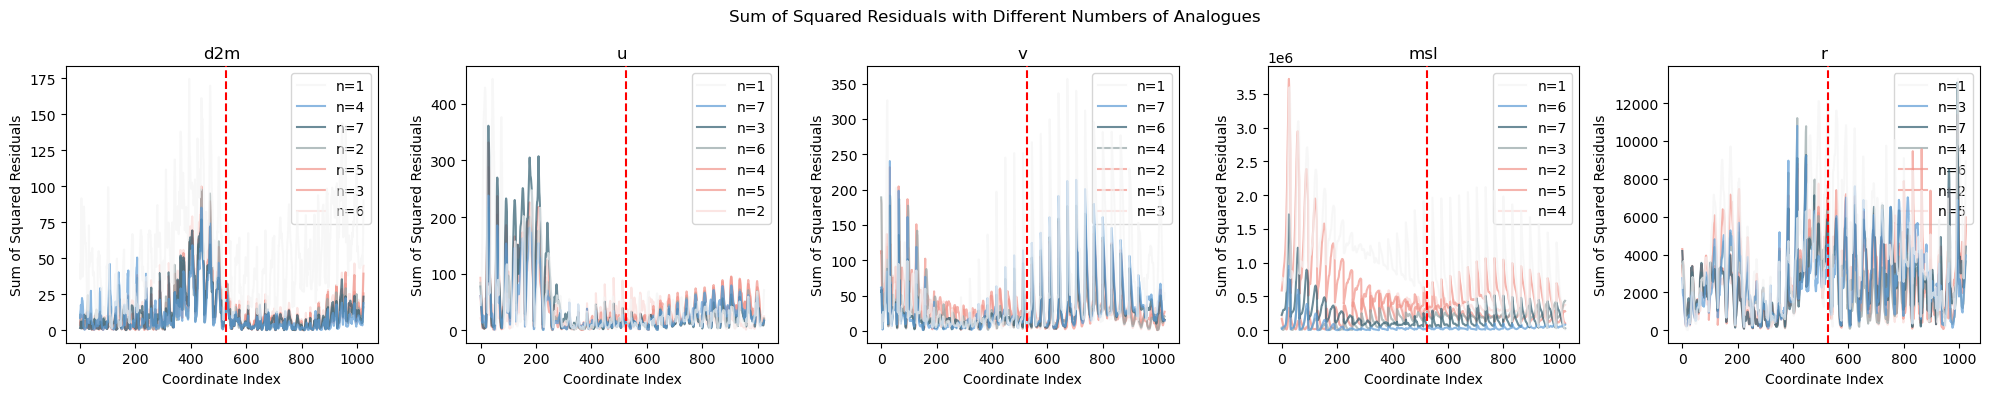

In [6]:
color_palette = ['#F5F5F5', '#5B9BD5', '#2E5C6E', '#95A5A6', '#F1948A', '#F1948A', '#FADBD8']

def calculate_ssr(analogs):
    keys = list(analogs.keys())
    data0 = np.array(analogs[keys[0]]['data'])  # 确保 data0 是 NumPy 数组

    data_lengths = [len(analogs[k]['data']) for k in keys]
    assert all(length == data_lengths[0] for length in data_lengths), "所有 data 列表的长度必须相同"

    num_channels = data0.shape[1]
    all_ssr = [[] for _ in range(num_channels)]  # 为每个通道创建一个空列表

    for i in range(1, len(keys)):
        data_keys = [np.array(analogs[keys[k]]['data']) for k in range(1, i + 1)]
        
        average_data = [np.mean([data[k] for data in data_keys], axis=0) for k in range(len(data0))]

        for ch in range(num_channels):
            ssr_sum = np.zeros((32, 32))
            for array0, avg_array in zip(data0, average_data):
                ssr_sum += (array0[ch] - avg_array[ch]) ** 2
            ssr_sum_flattened = ssr_sum.flatten()
            all_ssr[ch].append(ssr_sum_flattened)

    return all_ssr

def sort_ssr_by_index(ssr_values, specified_index, max_number):
    sorted_ssr_values = []
    for channel_ssr in ssr_values:
        # 保留 n=1 的部分，并包括在排序中
        n1_ssr = channel_ssr[0]
        other_ssr = channel_ssr[1:]
        sorted_ssr = sorted(enumerate(other_ssr, start=2), key=lambda x: x[1][specified_index])
        sorted_ssr = [(1, n1_ssr)] + sorted_ssr  # 包含 n=1 的部分
        sorted_ssr = sorted_ssr[:max_number]  # 确保输出的数量等于 max_number
        sorted_ssr_values.append(sorted_ssr)
    return sorted_ssr_values

# Calculate SSR values for different numbers of analogs
ssr_values = calculate_ssr(analogue_results_with_data)
max_number = 10  # Maximum number of analogs to display
sorted_ssr_values = sort_ssr_by_index(ssr_values, specified_index, max_number)
ignore_list = []  # List of analog numbers to ignore in visualization

# Create visualization: SSR for different numbers of analogs across all variables
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create 1x5 subplots

for ch in range(5):  # For each channel/variable
    plot_count = 0
    zorder_base = 100  # Initialize zorder base for proper layer ordering
    print(f"Channel {ch+1}: {variable_list[ch]}")
    
    for idx, (n_value, ssr) in enumerate(sorted_ssr_values[ch]):
        if n_value in ignore_list:
            continue
        axs[ch].plot(ssr, label=f'n={n_value}', alpha=0.7, 
                     color=color_palette[plot_count % len(color_palette)], 
                     zorder=zorder_base-plot_count)
        plot_count += 1
        print(f"  Plotting n={n_value}, plot_count={plot_count}")
    
    # Add vertical line at specified index
    axs[ch].axvline(x=specified_index, color='r', linestyle='--', zorder=zorder_base+1)
    
    # Set labels and title
    axs[ch].set_xlabel('Coordinate Index')
    axs[ch].set_ylabel('Sum of Squared Residuals')
    axs[ch].set_title(f'{variable_list[ch]}')
    axs[ch].legend(loc='upper right')

fig.suptitle('Sum of Squared Residuals with Different Numbers of Analogues', fontsize=12)
plt.tight_layout()
plt.show()


Channel 1: d2m
  Plotting n=1, plot_count=1
  Plotting n=4, plot_count=2
  Plotting n=7, plot_count=3
  Plotting n=2, plot_count=4
  Plotting n=5, plot_count=5
  Plotting n=3, plot_count=6
  Plotting n=6, plot_count=7
Channel 2: u
  Plotting n=1, plot_count=1
  Plotting n=7, plot_count=2
  Plotting n=3, plot_count=3
  Plotting n=6, plot_count=4
  Plotting n=4, plot_count=5
  Plotting n=5, plot_count=6
  Plotting n=2, plot_count=7
Channel 3: v
  Plotting n=1, plot_count=1
  Plotting n=7, plot_count=2
  Plotting n=6, plot_count=3
  Plotting n=4, plot_count=4
  Plotting n=2, plot_count=5
  Plotting n=5, plot_count=6
  Plotting n=3, plot_count=7
Channel 4: msl
  Plotting n=1, plot_count=1
  Plotting n=6, plot_count=2
  Plotting n=7, plot_count=3
  Plotting n=3, plot_count=4
  Plotting n=2, plot_count=5
  Plotting n=5, plot_count=6
  Plotting n=4, plot_count=7
Channel 5: r
  Plotting n=1, plot_count=1
  Plotting n=3, plot_count=2
  Plotting n=7, plot_count=3
  Plotting n=4, plot_count=4
  P

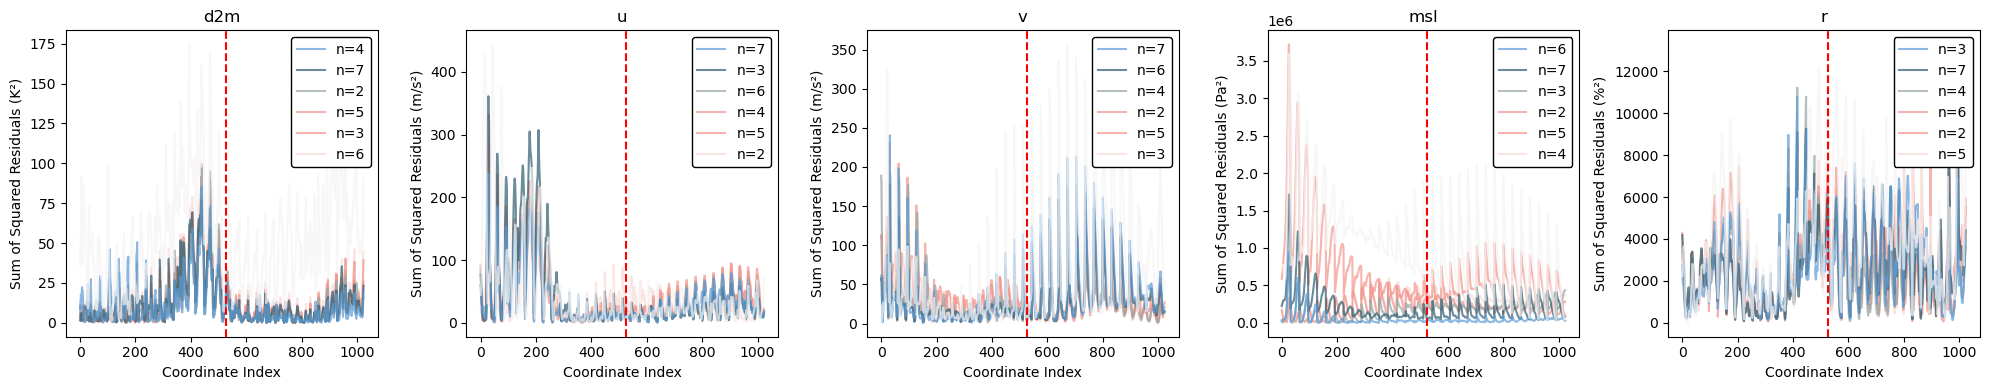

In [7]:
# Define variable units for better labeling
variable_units = ['K', 'm/s', 'm/s', 'Pa', '%']  # Temperature, wind speed, wind speed, pressure, humidity

# Create visualization: SSR with units, improved formatting
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for ch in range(5):
    plot_count = 0
    zorder_base = 100
    print(f"Channel {ch+1}: {variable_list[ch]}")
    
    for idx, (n_value, ssr) in enumerate(sorted_ssr_values[ch]):
        # Only label n>1 values (n=1 serves as reference)
        label = None if n_value == 1 else f'n={n_value}'
        
        axs[ch].plot(ssr, label=label, 
                     alpha=0.7, color=color_palette[plot_count % len(color_palette)], 
                     zorder=zorder_base-plot_count)
        plot_count += 1
        print(f"  Plotting n={n_value}, plot_count={plot_count}")
    
    # Add vertical line at specified index
    axs[ch].axvline(x=specified_index, color='r', linestyle='--', zorder=zorder_base+1)
    
    # Set labels with units
    axs[ch].set_xlabel('Coordinate Index')
    axs[ch].set_ylabel(f'Sum of Squared Residuals ({variable_units[ch]}²)')
    axs[ch].set_title(f'{variable_list[ch]}')
    
    # Create legend with better visibility
    legend = axs[ch].legend(loc='upper right', framealpha=1, facecolor='white', edgecolor='black')
    legend.set_zorder(200)  # Ensure legend is on top

plt.tight_layout()
plt.show()


/tmp/ipykernel_274484/2471420367.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


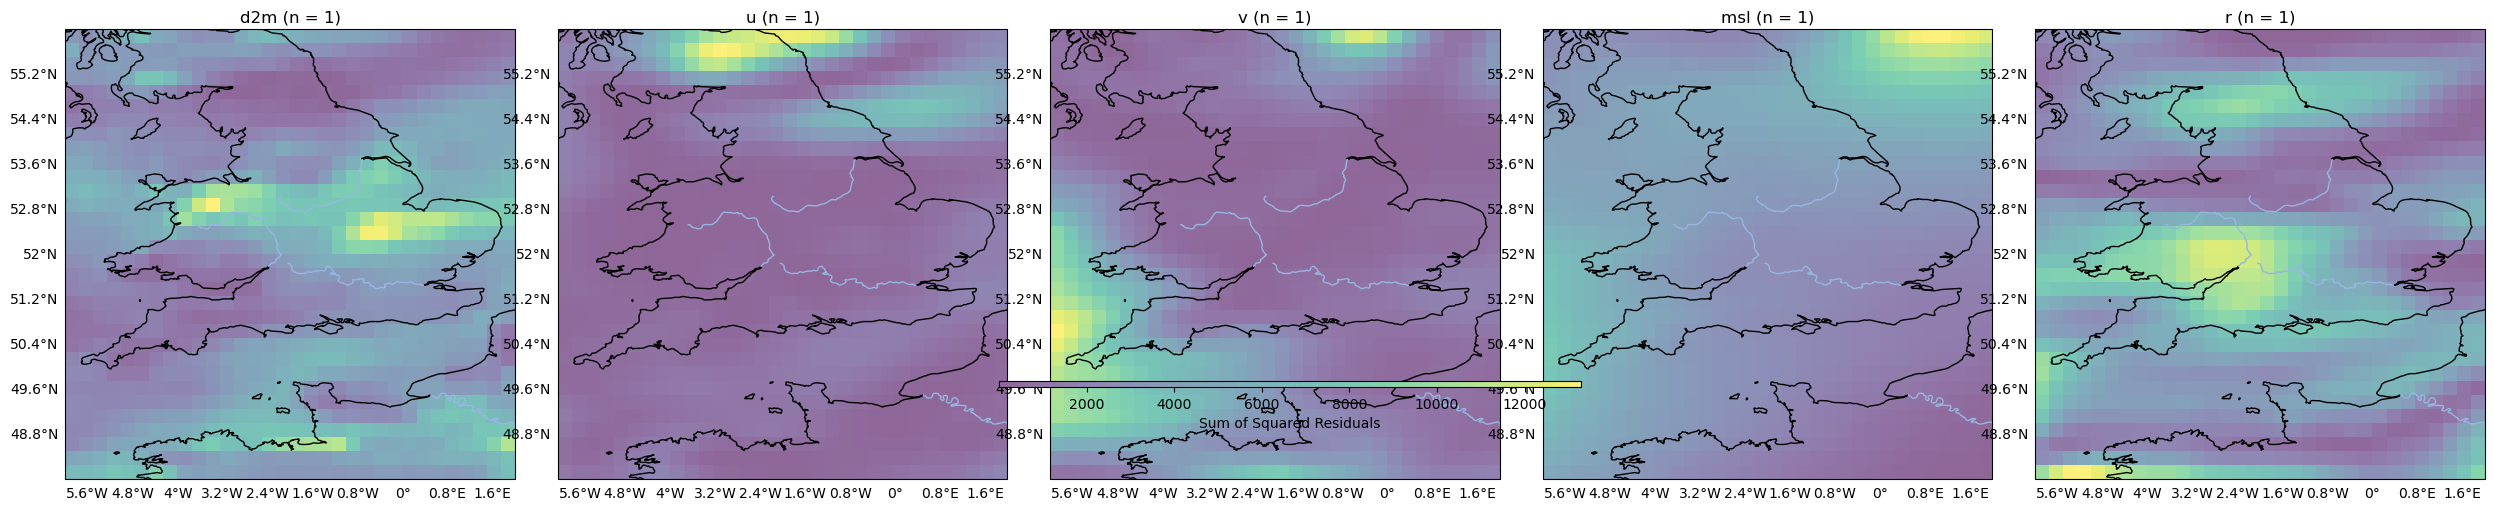

In [8]:
# Create visualization: SSR heatmaps on map for each variable
fig, axs = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={"projection": ccrs.PlateCarree()})

for ch in range(5):
    # Find n=9 for visualization (or use first available if n=9 not present)
    target_number = sorted_ssr_values[ch][0][0]
    target_ssr = sorted_ssr_values[ch][0][1]
    
    for ssr_values in sorted_ssr_values[ch]:
        if ssr_values[0] == 9:
            target_number = ssr_values[0]
            target_ssr = ssr_values[1]  
            break

    if target_ssr is not None:
        # Reshape flattened SSR to 2D grid
        target_ssr_matrix = target_ssr.reshape(32, 32)
        
        # Set map extent to cover UK
        axs[ch].set_extent([-6, 2, 48, 56])
        
        # Add map features
        axs[ch].add_feature(cfeature.COASTLINE)
        axs[ch].add_feature(cfeature.BORDERS, linestyle=":")
        axs[ch].add_feature(cfeature.RIVERS)
        axs[ch].add_feature(cfeature.LAKES)
        
        # Add grid lines
        gl = axs[ch].gridlines(draw_labels=True, linewidth=0, color="gray", alpha=0.5, linestyle="--")
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = plt.MaxNLocator(12)
        gl.ylocator = plt.MaxNLocator(12)
        
        # Display SSR values as heatmap
        img = axs[ch].imshow(target_ssr_matrix, extent=[-6, 2, 48, 56], origin='upper', 
                           transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.6)
        
        # Set subplot title
        axs[ch].set_title(f'{variable_list[ch]} (n = {target_number})')
    else:
        print(f"No data found for channel {ch+1}")

# Add colorbar
cbar = fig.colorbar(img, ax=axs.ravel().tolist(), orientation='horizontal', 
                   pad=0.1, aspect=100, shrink=0.3)
cbar.set_label('Sum of Squared Residuals')

plt.tight_layout()
plt.show()


## Five Methods Comparison

In [9]:
import os
import json

# Define parameters for multi-method comparison
project = "first_stage"
similarity_methods = [
    "atmodist_similarity",    # AtmoDist neural model
    "weighted_similarity",    # AtmoDist with spatial weighting
    "euclidean_similarity",   # Traditional Euclidean distance
    "cosine_similarity",      # Traditional cosine similarity 
    "ssim_similarity"         # Structural similarity index
]
event_index = 24  # Event to analyze
methods_name = ["AtmoDist", "AtmoDist-SW", "Euclidean", "Cosine", "SSIM"]  # Display names

# Dictionary to store results for each method
analogue_results_with_data_dict = {}

# Load analogs for each method
for method in similarity_methods:
    directory = f'../data/analogs/{project}'
    file_path = f'{directory}/{method}.json'
    
    # Ensure directory and file exist
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist. Skipping method: {method}")
        continue
    
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist. Skipping method: {method}")
        continue
    
    try:
        # Load JSON file
        with open(file_path, 'r') as f:
            all_results = json.load(f)
        
        # Check if event index is valid
        if not (0 <= event_index < len(all_results)):
            print(f"Event index {event_index} is out of range for method: {method}. Skipping.")
            continue
        
        # Get analogs for the specific event
        analogs_single_event = all_results[event_index]
        
        # Attach data to analogs
        analogue_results_with_data = attach_data_to_analogs(
            all_variables_data,
            analogs_single_event
        )
        
        # Store results in dictionary
        analogue_results_with_data_dict[method] = analogue_results_with_data
        print(f"Processed analogs for method: {method}")
        
    except Exception as e:
        print(f"Error processing method {method}: {e}")

# Extract individual method results for easier access
atmodist_analogue_results_with_data = analogue_results_with_data_dict.get("atmodist_similarity")
weighted_analogue_results_with_data = analogue_results_with_data_dict.get("weighted_similarity")
euclidean_analogue_results_with_data = analogue_results_with_data_dict.get("euclidean_similarity")
cosine_analogue_results_with_data = analogue_results_with_data_dict.get("cosine_similarity")
ssim_analogue_results_with_data = analogue_results_with_data_dict.get("ssim_similarity")

# Create dictionary with better method names for analysis
analogs_dict = {
    'atmodist': atmodist_analogue_results_with_data,
    "weighted": weighted_analogue_results_with_data,
    'euclidean': euclidean_analogue_results_with_data,
    'cosine': cosine_analogue_results_with_data,
    "ssim": ssim_analogue_results_with_data
}

# Remove any None values (methods that weren't loaded)
analogs_dict = {k: v for k, v in analogs_dict.items() if v is not None}
print(f"Successfully loaded {len(analogs_dict)} analogue methods")




Processed analogs for method: atmodist_similarity
Processed analogs for method: weighted_similarity
Processed analogs for method: euclidean_similarity
Processed analogs for method: cosine_similarity
Processed analogs for method: ssim_similarity
Successfully loaded 5 analogue methods


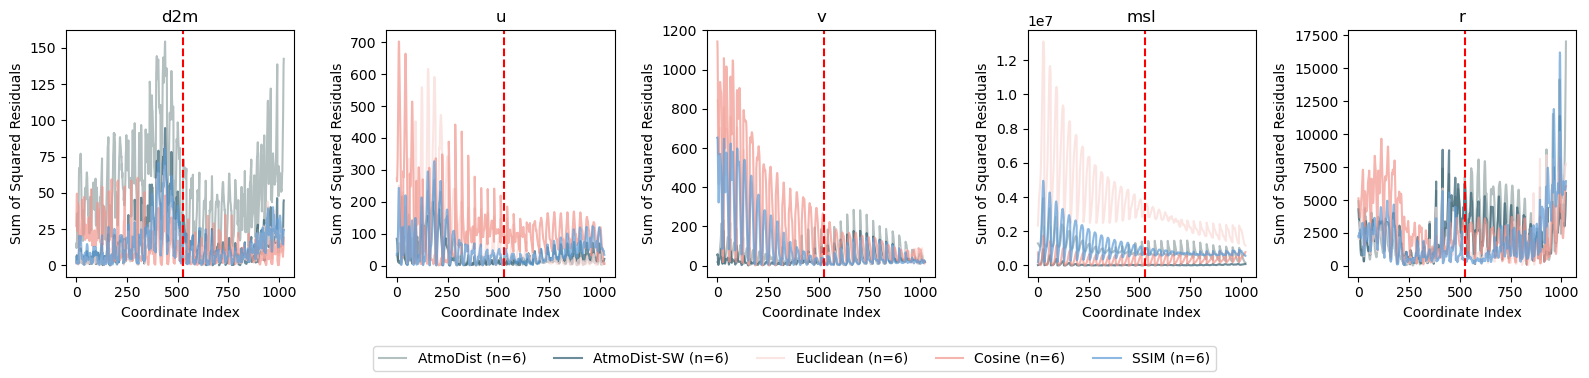

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define color palette for method visualization 
color_palette = ['#95A5A6', '#2E5C6E', '#FADBD8', '#F1948A', '#5B9BD5']
methods_name = ["AtmoDist", "AtmoDist-SW","Euclidean", "Cosine", "SSIM"]

# 計算 Sum of Squared Residuals (SSR)
def calculate_ssr(analogs_dict, n):
    keys = list(analogs_dict.keys())
    data0 = np.array(analogs_dict[keys[0]]['data'])  # 取出第一個方法的數據
    data_lengths = [len(analogs_dict[k]['data']) for k in keys]
    assert all(length == data_lengths[0] for length in data_lengths), "所有 data 列表的长度必须相同"

    num_channels = data0.shape[1]
    all_ssr = [[] for _ in range(num_channels)]  # 为每个通道创建一个空列表

    if n > len(keys):
        raise ValueError(f"指定的n={n}超過了可用的方法數={len(keys)}")

    data_keys = [np.array(analogs_dict[keys[k]]['data']) for k in range(1, n+1)]
    average_data = [np.mean([data[k] for data in data_keys], axis=0) for k in range(len(data0))]

    for ch in range(num_channels):
        ssr_sum = np.zeros((32, 32))
        for array0, avg_array in zip(data0, average_data):
            ssr_sum += (array0[ch] - avg_array[ch]) ** 2
        ssr_sum_flattened = ssr_sum.flatten()
        all_ssr[ch].append(ssr_sum_flattened)

    return all_ssr

# 繪製指定 n 的 SSR 曲線圖
def plot_ssr(analogs_dict, specified_index, n):
    """
    Plot SSR curves for multiple methods.
    
    Parameters:
    -----------
    analogs_dict : dict
        Dictionary containing analogs from different methods
    specified_index : int
        Grid index to highlight with vertical line
    n : int
        Number of analogs to use for each method
    """
    fig, axs = plt.subplots(1, 5, figsize=(16, 4))
    all_ssr_values = {method: calculate_ssr(analogs_dict[method], n) for method in analogs_dict.keys()}

    for ch in range(5):
        for idx, (method, ssr_values) in enumerate(all_ssr_values.items()):
            ssr = ssr_values[ch][0]  # 只取 n 的結果
            axs[ch].plot(ssr, label=f'{methods_name[idx]} (n={n})', 
                        alpha=0.7, color=color_palette[idx % len(color_palette)])  # 使用相同顏色方案
        
        # Add vertical line at specified index
        axs[ch].axvline(x=specified_index, color='r', linestyle='--')
        
        # Set labels
        axs[ch].set_xlabel('Coordinate Index')
        axs[ch].set_ylabel('Sum of Squared Residuals')
        axs[ch].set_title(variable_list[ch])
    
    # Create combined legend at bottom of figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(analogs_dict))

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # 調整圖表尺寸以避免擠壓
    plt.show()

# 繪製每個方法在 local_indices_list 中獲得第一名次數的長條圖，並在同一圖表中顯示兩組數據
def plot_combined_histogram(analogs_dict, specified_index, local_indices_list, n):
    """
    Plot combined histogram showing first place counts for different methods.
    
    Parameters:
    -----------
    analogs_dict : dict
        Dictionary containing analogs from different methods
    specified_index : int
        Grid index to highlight
    local_indices_list : list
        List of indices considered in local analysis
    n : int
        Number of analogs to use for each method
    """
    methods = list(analogs_dict.keys())
    num_methods = len(methods)
    first_place_counts = defaultdict(lambda: [0] * 5)  # 每個方法在5個通道中的第一名次數
    local_first_place_counts = defaultdict(lambda: [0] * 5)  # 每個方法在 local_indices_list 中的第一名次數

    # 計算每個方法的SSR
    all_ssr_values = {method: calculate_ssr(analogs_dict[method], n) for method in methods}

    # 統計每個通道的第一名次數
    for ch in range(5):  # 針對每個通道進行排名
        for idx in range(all_ssr_values[methods[0]][ch][0].size):  # 遍歷每個 index
            ssr_values_at_idx = {method: all_ssr_values[method][ch][0][idx] for method in methods}
            sorted_methods_at_idx = sorted(ssr_values_at_idx.items(), key=lambda x: x[1])  # 排序，SSR 值最小的為第一名
            first_place_method = sorted_methods_at_idx[0][0]  # 獲得第一名的方式
            first_place_counts[first_place_method][ch] += 1  # 該方法在此通道增加一個第一名次數

        # 統計 local_indices_list 中的第一名次數
        for idx in local_indices_list:
            ssr_values_at_idx = {method: all_ssr_values[method][ch][0][idx] for method in methods}
            sorted_methods_at_idx = sorted(ssr_values_at_idx.items(), key=lambda x: x[1])
            first_place_method = sorted_methods_at_idx[0][0]
            local_first_place_counts[first_place_method][ch] += 1

    # 準備繪製長條圖
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    x_positions = np.arange(5)  # 5 個通道
    bar_containers = []  # 用來存放每個方法的BarContainer

    # 繪製每個方法在 5 個通道中的第一名次數 (左側 y 軸)
    for idx, method in enumerate(methods):
        counts = first_place_counts[method]  # 該方法在每個通道的第一名次數
        bars = ax1.bar(x_positions + idx * bar_width - bar_width / 2, counts, bar_width, 
                      label=f'{method} (Total)', color=color_palette[idx % len(color_palette)], alpha=1)
        bar_containers.append(bars)  # 保存 BarContainer

    ax1.set_ylabel('Total First Places')
    ax1.set_xticks(x_positions + bar_width * (num_methods - 1) / 2)
    ax1.set_xticklabels(variable_list)

    # 創建第二個 y 軸，繪製 local_indices_list 的數據
    ax2 = ax1.twinx()  # 創建一個共享 x 軸的 y 軸
    hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # 定義不同的 hatch 樣式
    for idx, method in enumerate(methods):
        local_counts = local_first_place_counts[method]
        # 為了讓第二組長條圖不與第一組重疊，將 x 軸位置偏移
        bars = ax2.bar(x_positions + idx * bar_width + bar_width / 2, local_counts, bar_width, 
                      label=f'{method} (Local)', color=color_palette[idx % len(color_palette)], 
                      hatch=hatch_patterns[0], edgecolor='black', alpha=0.6)

    ax2.set_ylabel('Local First Places')

    # 合併圖例
    fig.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

    plt.tight_layout()
    plt.show()

# 使用範例資料集調用函數

n = 6  # 這裡指定n為6

# 畫出不同方法結果的SSR曲線圖
plot_ssr(analogs_dict, specified_index, n)

# 畫出不同方法在每個通道中獲得第一名次數的長條圖，並在圖中添加 local_indices_list 的長條圖
# plot_combined_histogram(analogs_dict, specified_index, local_indices_list, n)


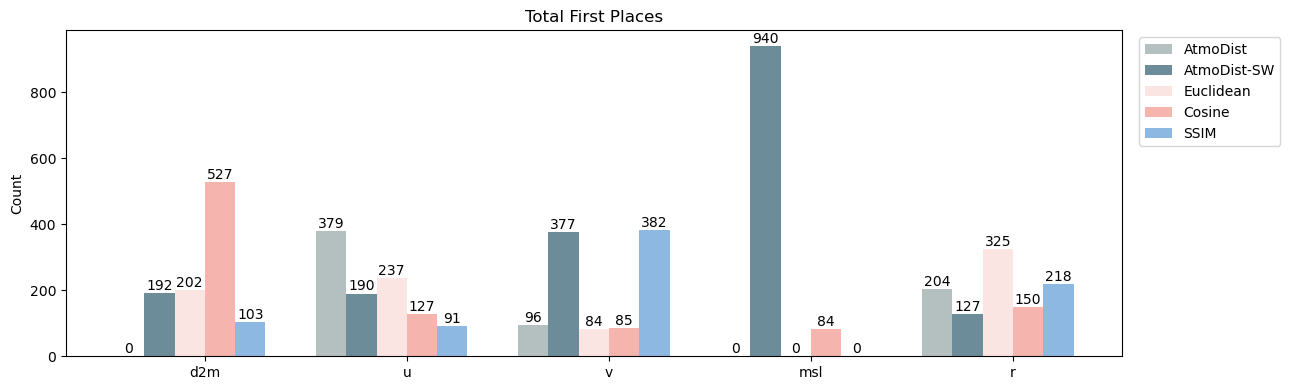

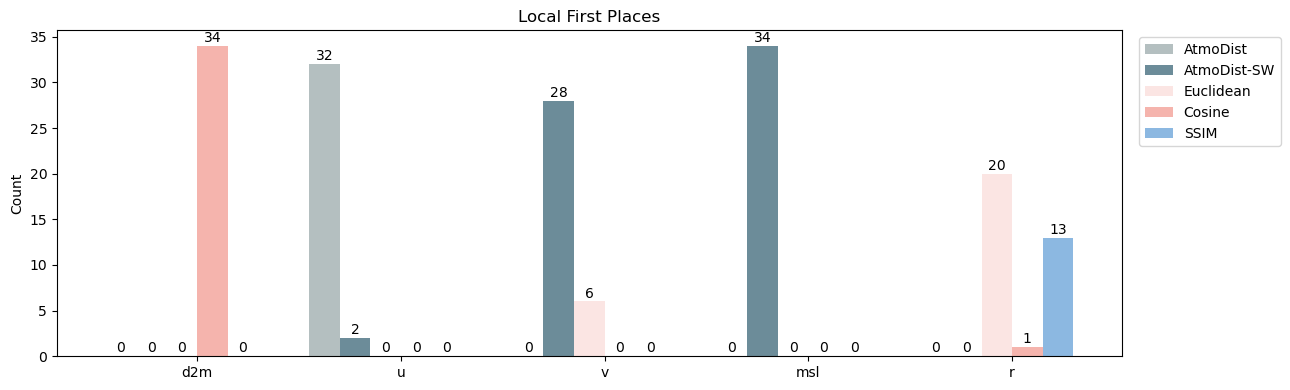

In [11]:
def plot_separate_histograms(analogs_dict, specified_index, local_indices_list, n):
    """
    Plot separate histograms for total and local first place counts.
    
    Parameters:
    -----------
    analogs_dict : dict
        Dictionary containing analogs from different methods
    specified_index : int
        Grid index to highlight
    local_indices_list : list
        List of indices considered in local analysis
    n : int
        Number of analogs to use for each method
    """
    methods = list(analogs_dict.keys())
    num_methods = len(methods)
    first_place_counts = defaultdict(lambda: [0] * 5)  # Count for each method in 5 channels
    local_first_place_counts = defaultdict(lambda: [0] * 5)  # Count in local_indices_list

    # Calculate SSR for each method
    all_ssr_values = {method: calculate_ssr(analogs_dict[method], n) for method in methods}

    # Count first places for each channel
    for ch in range(5):
        for idx in range(all_ssr_values[methods[0]][ch][0].size):
            ssr_values_at_idx = {method: all_ssr_values[method][ch][0][idx] for method in methods}
            sorted_methods_at_idx = sorted(ssr_values_at_idx.items(), key=lambda x: x[1])
            first_place_method = sorted_methods_at_idx[0][0]
            first_place_counts[first_place_method][ch] += 1

        # Count first places in local_indices_list
        for idx in local_indices_list:
            ssr_values_at_idx = {method: all_ssr_values[method][ch][0][idx] for method in methods}
            sorted_methods_at_idx = sorted(ssr_values_at_idx.items(), key=lambda x: x[1])
            first_place_method = sorted_methods_at_idx[0][0]
            local_first_place_counts[first_place_method][ch] += 1

    # Plot total first place counts
    fig1, ax1 = plt.subplots(figsize=(13, 4))
    bar_width = 0.15
    x_positions = np.arange(5)

    for idx, method in enumerate(methods):
        counts = first_place_counts[method]
        positions = x_positions + idx * bar_width - (num_methods * bar_width) / 2
        bars = ax1.bar(
            positions,
            counts,
            bar_width,
            label=methods_name[idx],
            color=color_palette[idx % len(color_palette)],
            alpha=0.7
        )
        # Add count labels
        for bar, count in zip(bars, counts):
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(count),
                     ha='center', va='bottom', fontsize=10, color='black')

    ax1.set_ylabel('Count')
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(variable_list)
    ax1.set_title('Total First Places')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

    plt.tight_layout()
    plt.show()

    # Plot local first place counts
    fig2, ax2 = plt.subplots(figsize=(13, 4))

    for idx, method in enumerate(methods):
        local_counts = local_first_place_counts[method]
        positions = x_positions + idx * bar_width - (num_methods * bar_width) / 2
        bars = ax2.bar(
            positions,
            local_counts,
            bar_width,
            label=methods_name[idx],
            color=color_palette[idx % len(color_palette)],
            alpha=0.7
        )
        # Add count labels
        for bar, count in zip(bars, local_counts):
            ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(count),
                     ha='center', va='bottom', fontsize=10, color='black')

    ax2.set_ylabel('Count')
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(variable_list)
    ax2.set_title('Local First Places')
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

    plt.tight_layout()
    plt.show()

# Plot separate histograms for n=6 analogs
n = 6
plot_separate_histograms(analogs_dict, specified_index, local_indices_list, n)


### -Rank Histogram

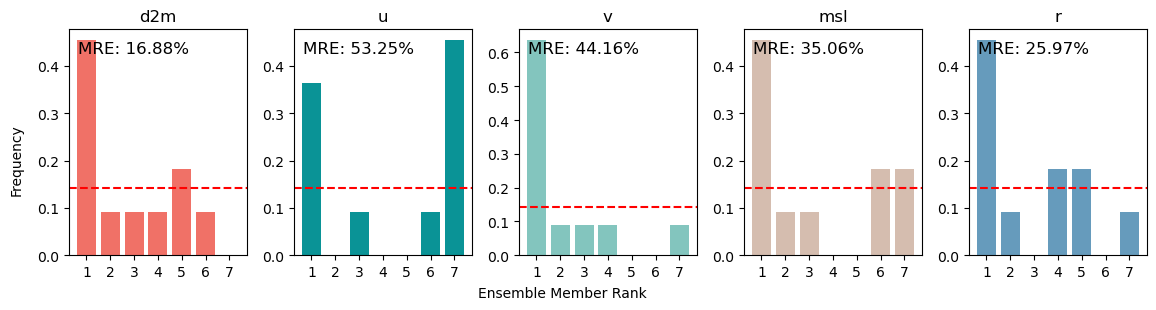

In [12]:
def calculate_normalized_rank_histogram(observation, predictions):
    num_ensemble_members = len(predictions) + 1  # 包括所有预测成员和实际观察值
    rank_counts = np.zeros(num_ensemble_members)  # 初始化排名计数器

    for obs_index, obs in enumerate(observation):
        all_values = [pred[obs_index] for pred in predictions]  # 获取当前观察值对应的所有预测值
        all_values.append(obs)  # 添加观察值本身
        all_values_sorted = sorted(all_values)  # 排序所有值
        rank = all_values_sorted.index(obs)  # 观察值在排序后的列表中的索引即为其排名
        rank_counts[rank] += 1  # 更新该排名的计数

    normalized_rank_counts = rank_counts / rank_counts.sum()  # 将频率总和正规化为1
    return normalized_rank_counts

def calculate_MRE(rank_histogram, M):
    f1 = rank_histogram[0]  # 第一个箱子的频率
    fM = rank_histogram[-1]  # 最后一个箱子的频率
    MRE = f1 + fM - (2 / (M + 1))
    return MRE

def plot_rank_histogram(analog_dictionary, specified_index, num_analogs_to_plot):
    """
    Plot rank histograms for ensemble predictions.
    
    Parameters:
    -----------
    analog_dictionary : dict
        Dictionary containing analog data
    specified_index : int
        Grid index to analyze
    num_analogs_to_plot : int
        Number of analogs to include in ensemble
    """
    num_channels = 5
    colors = ['#f07167', '#0a9396', '#83c5be', '#d5bdaf', '#669bbc']
    
    fig, axs = plt.subplots(1, num_channels, figsize=(12, 3), sharex=True)

    for ch in range(num_channels):
        # Extract observations and predictions
        all_observations = []
        all_predictions = []

        for key, value in analog_dictionary.items():
            data = value['data']
            # Extract value at specified grid point for observation
            observation = data[0][ch, specified_index // 32, specified_index % 32]
            
            # Extract values for predictions (analogs)
            predictions = [data[i][ch, specified_index // 32, specified_index % 32] 
                          for i in range(1, min(num_analogs_to_plot+1, len(data)))]

            all_observations.append(observation)
            
            # Organize predictions by ensemble member
            for i in range(len(predictions)):
                if len(all_predictions) <= i:
                    all_predictions.append([])
                all_predictions[i].append(predictions[i])

        # Convert to numpy arrays
        all_observations = np.array(all_observations)
        all_predictions = [np.array(pred) for pred in all_predictions]

        # Calculate rank histogram and MRE
        normalized_rank_histogram = calculate_normalized_rank_histogram(all_observations, all_predictions)
        MRE_value = calculate_MRE(normalized_rank_histogram, len(all_predictions))

        # Plot histogram bars
        bars = axs[ch].bar(range(1, len(normalized_rank_histogram) + 1), 
                          normalized_rank_histogram, color=colors[ch])
        
        # Add ideal frequency line
        ideal_frequency = 1.0 / (len(all_predictions) + 1)
        axs[ch].axhline(y=ideal_frequency, color="r", linestyle="--")

        # Set title and ticks
        axs[ch].set_title(f"{variable_list[ch]}")
        axs[ch].set_xticks(range(1, len(normalized_rank_histogram) + 1))
        
        # Add MRE label
        axs[ch].text(0.05, 0.95, f"MRE: {MRE_value:.2%}", 
                    horizontalalignment="left", verticalalignment="top",
                    transform=axs[ch].transAxes, color="black", fontsize=12)

    # Add global labels
    fig.text(0.5, 0.04, 'Ensemble Member Rank', ha='center')
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

    plt.tight_layout(rect=[0.05, 0.05, 1, 1.05])
    plt.show()

# Plot rank histogram for the single event
plot_rank_histogram(analogue_results_with_data, specified_index=specified_index, num_analogs_to_plot=9)


## Skill Spread

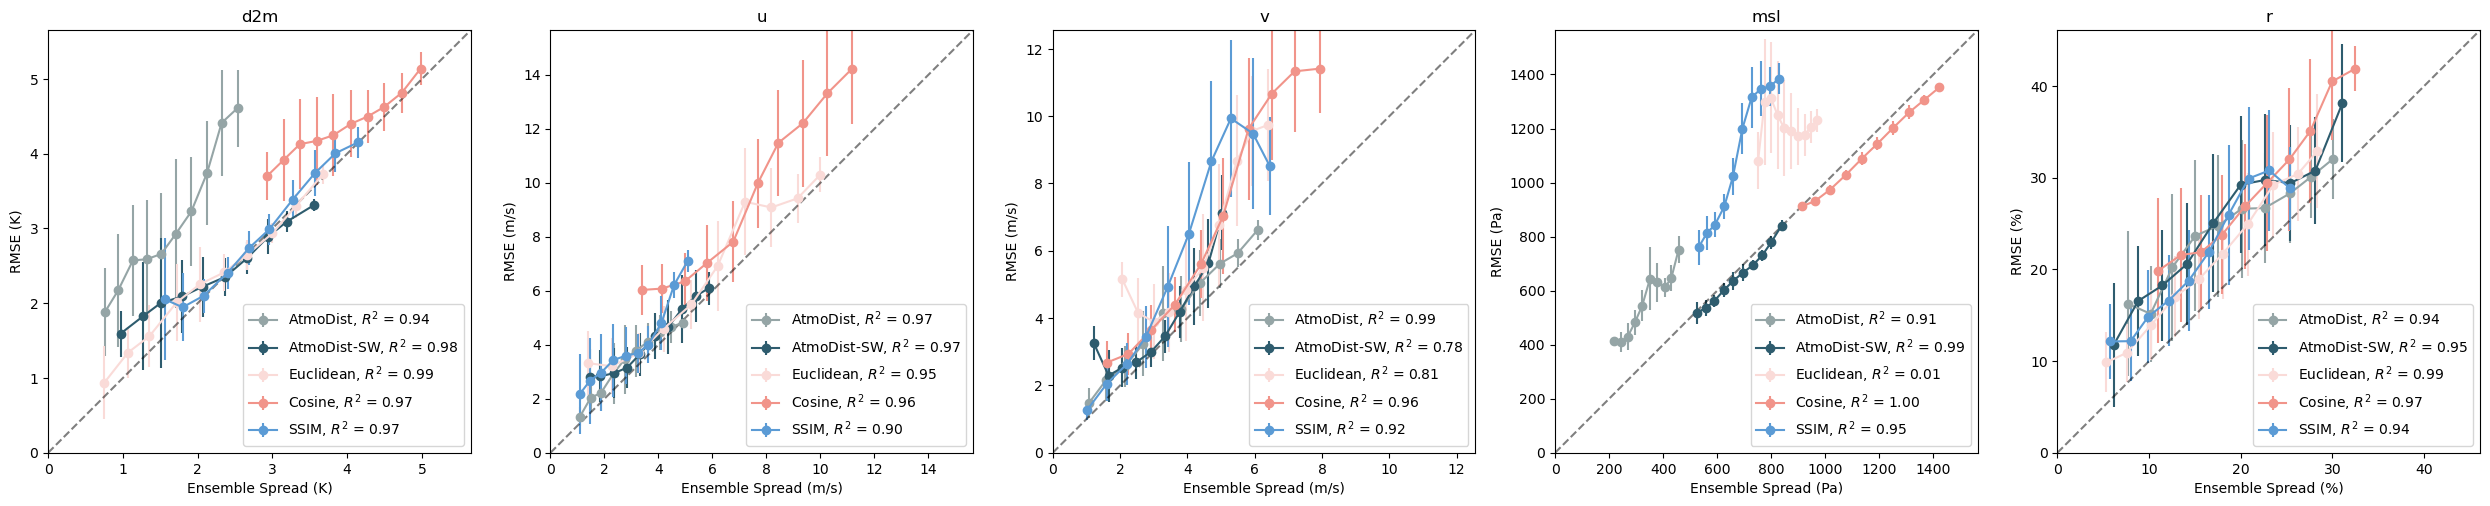

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define variable names and units
variable_list = ["d2m", "u", "v", "msl", "r"]
variable_units = ["K", "m/s", "m/s", "Pa", "%"]  # Temperature, wind speed, wind speed, pressure, humidity

# Extract observed data (reference data from first member)
observed_data = np.array([t for t in atmodist_analogue_results_with_data["0"]["data"]])  
# observed_data 的形状应为 (num_timesteps, 5, 32, 32)

# 提取预测数据的函数（跳过第0个成员）
def extract_predictions(dict_data):
    predictions = []
    for key in dict_data:
        if key == "0":  # 跳过观测数据或参考数据
            continue
        member_data = np.array([t for t in dict_data[key]['data']])  
        # member_data 的形状应为 (num_timesteps, 5, 32, 32)
        predictions.append(member_data)
    return np.array(predictions)  # 返回形状为 (num_members, num_timesteps, 5, 32, 32)

def calculate_spread_and_rmse(predictions, observations, channel):
    """
    Calculate ensemble spread and RMSE for each grid point.
    
    Parameters:
    -----------
    predictions : array-like
        Ensemble predictions with shape (num_members, num_timesteps, num_channels, height, width)
    observations : array-like
        Observation data with shape (num_timesteps, num_channels, height, width)
    channel : int
        Channel index to analyze
        
    Returns:
    --------
    tuple
        (spreads, rmses) arrays containing spread and RMSE values
    """
    num_members, num_timesteps, num_channels, num_x, num_y = predictions.shape
    spreads = np.zeros((num_timesteps, num_x, num_y))
    rmses = np.zeros((num_timesteps, num_x, num_y))
    
    for t in range(num_timesteps):
        # Extract predictions and observation for current timestep
        preds_at_t = predictions[:, t, channel, :, :]  # Shape: (num_members, 32, 32)
        obs_at_t = observations[t, channel, :, :]      # Shape: (32, 32)
        
        # Calculate spread (standard deviation across ensemble members)
        spreads[t, :, :] = np.std(preds_at_t, axis=0, ddof=1)
        
        # Calculate RMSE (root mean squared error between predictions and observation)
        rmses[t, :, :] = np.sqrt(np.mean((preds_at_t - obs_at_t) ** 2, axis=0))
    
    return spreads, rmses

def bin_data(spreads, rmses, num_bins=10):
    """
    Bin spread and RMSE data for clearer visualization.
    
    Parameters:
    -----------
    spreads : array-like
        Spread values
    rmses : array-like
        RMSE values
    num_bins : int
        Number of bins for binning
        
    Returns:
    --------
    tuple
        (binned_spread_means, binned_rmse_means, binned_rmse_stds)
    """
    bins = np.linspace(np.nanmin(spreads), np.nanmax(spreads), num_bins + 1)
    bins[-1] += 1e-8  # Ensure maximum value is included in last bin
    bin_indices = np.digitize(spreads, bins, right=True)

    binned_spread_means = []
    binned_rmse_means = []
    binned_rmse_stds = []

    for i in range(1, num_bins + 1):
        bin_mask = bin_indices == i
        bin_spreads = spreads[bin_mask]
        bin_rmses = rmses[bin_mask]

        if len(bin_spreads) > 0:
            binned_spread_means.append(np.nanmean(bin_spreads))
            binned_rmse_means.append(np.nanmean(bin_rmses))
            binned_rmse_stds.append(np.nanstd(bin_rmses))

    return binned_spread_means, binned_rmse_means, binned_rmse_stds

# Create spread-skill plots for each variable
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=False)

for channel in range(5):
    ax = axes[channel]
    max_val = 0  # Initialize maximum value for diagonal line

    # Process each method
    for dataset_idx, (dataset_name, dataset) in enumerate(analogs_dict.items()):
        # Extract predictions
        predictions = extract_predictions(dataset)
        
        # Calculate spread and RMSE
        spreads, rmses = calculate_spread_and_rmse(predictions, observed_data, channel)
        
        # Flatten arrays for analysis
        spreads_flat = spreads.flatten()
        rmses_flat = rmses.flatten()

        # Filter out invalid values
        valid_indices = np.isfinite(spreads_flat) & np.isfinite(rmses_flat)
        filtered_spreads = spreads_flat[valid_indices]
        filtered_rmses = rmses_flat[valid_indices]

        if len(filtered_spreads) == 0 or len(filtered_rmses) == 0:
            continue  # Skip if no valid data

        # Bin data for visualization
        binned_spread_means, binned_rmse_means, binned_rmse_stds = bin_data(filtered_spreads, filtered_rmses)

        if len(binned_spread_means) == 0 or len(binned_rmse_means) == 0:
            continue  # Skip if binning resulted in no data

        # Calculate regression statistics
        slope, intercept, r_value, p_value, std_err = linregress(binned_spread_means, binned_rmse_means)
        r2 = r_value**2  # R-squared value

        # Plot error bars with means
        color = color_palette[dataset_idx % len(color_palette)]
        ax.errorbar(
            binned_spread_means, binned_rmse_means, 
            yerr=binned_rmse_stds, 
            fmt='o-', color=color, 
            label=f'{methods_name[dataset_idx]}, $R^2$ = {r2:.2f}'
        )

        # Update maximum value for diagonal line
        current_max = max(max(binned_spread_means), max(binned_rmse_means))
        max_val = max(max_val, current_max)

    if max_val == 0:
        continue  # Skip if no data to plot

    # Add 10% margin to maximum value
    max_val *= 1.1

    # Draw diagonal line (ideal spread=skill relationship)
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

    # Set axis limits and scale
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_aspect('equal', adjustable='box')

    # Add labels with units
    ax.set_xlabel(f'Ensemble Spread ({variable_units[channel]})')
    ax.set_ylabel(f'RMSE ({variable_units[channel]})')
    ax.set_title(f'{variable_list[channel]}')

    # Add legend
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


## Modular Visualization Examples

The following cells demonstrate the modular and independent visualization functions for weather analogue analysis. Each cell focuses on a specific type of visualization with clear documentation and flexible configuration options.

In [14]:
import os
import json

# Define parameters for precipitation analysis
project = "first_stage"
similarity_methods = [
    "atmodist_similarity",    # AtmoDist neural model
    "weighted_similarity",    # AtmoDist with spatial weighting
    "euclidean_similarity",   # Traditional Euclidean distance
    "cosine_similarity"       # Traditional cosine similarity
]
event_index = 24  # Event to analyze

print(f"Loading precipitation analogs for event {event_index}")

# Dictionary to store precipitation results
analogue_results_with_data_dict = {}

# Load precipitation analogs for each method
for method in similarity_methods:
    directory = f'../data/analogs/{project}'
    file_path = f'{directory}/{method}.json'
    
    # Ensure directory and file exist
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist. Skipping method: {method}")
        continue
    
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist. Skipping method: {method}")
        continue
    
    try:
        # Load JSON file
        with open(file_path, 'r') as f:
            prep_results = json.load(f)
        
        # Check if event index is valid
        if not (0 <= event_index < len(prep_results)):
            print(f"Event index {event_index} is out of range for method: {method}. Skipping.")
            continue
        
        # Get analogs for the specific event
        analogs_single_event = prep_results[event_index]
        
        # Attach precipitation data to analogs
        analogue_results_with_data = attach_data_to_analogs(
            prep_data,  # Use precipitation data
            analogs_single_event
        )
        
        # Store results in dictionary
        analogue_results_with_data_dict[method] = analogue_results_with_data
        print(f"Processed precipitation analogs for method: {method}")
        
    except Exception as e:
        print(f"Error processing precipitation analogs for method {method}: {e}")

# Extract individual method results for easier access
atmodist_analogue_results_with_data = analogue_results_with_data_dict.get("atmodist_similarity")
weighted_analogue_results_with_data = analogue_results_with_data_dict.get("weighted_similarity")
euclidean_analogue_results_with_data = analogue_results_with_data_dict.get("euclidean_similarity")
cosine_analogue_results_with_data = analogue_results_with_data_dict.get("cosine_similarity")

# Create dictionary with method names for analysis
analogs_dict = {
    'atmodist': atmodist_analogue_results_with_data,
    "weighted": weighted_analogue_results_with_data,
    'euclidean': euclidean_analogue_results_with_data,
    'cosine': cosine_analogue_results_with_data
}

# Remove any None values (methods that weren't loaded)
analogs_dict = {k: v for k, v in analogs_dict.items() if v is not None}
print(f"Successfully loaded precipitation data for {len(analogs_dict)} analogue methods")




Loading precipitation analogs for event 24
Processed precipitation analogs for method: atmodist_similarity
Processed precipitation analogs for method: weighted_similarity
Processed precipitation analogs for method: euclidean_similarity
Processed precipitation analogs for method: cosine_similarity
Successfully loaded precipitation data for 4 analogue methods


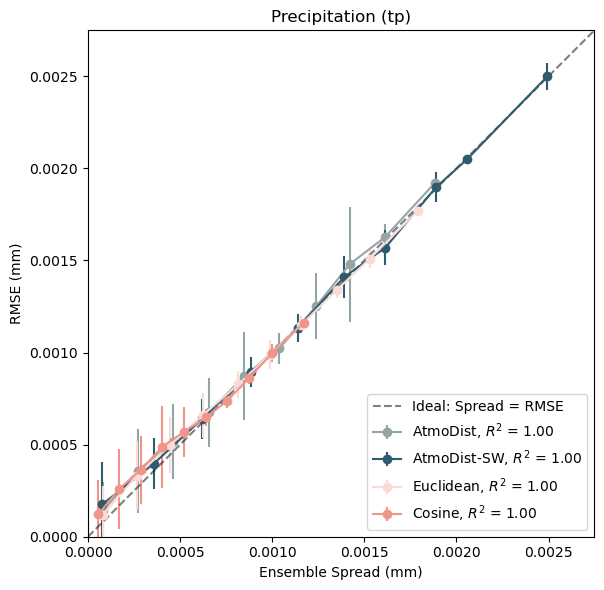

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define precipitation variable
variable_list = ["tp"]  # tp = total precipitation

# Extract reference data
observed_data = np.array([t for t in atmodist_analogue_results_with_data["0"]["data"]])

def plot_precipitation_spread_skill(data_sets, observed_data):
    """
    Plot spread-skill relationship for precipitation data.
    
    Parameters:
    -----------
    data_sets : dict
        Dictionary containing precipitation analogs from different methods
    observed_data : array-like
        Reference precipitation data
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    max_val = 0

    for dataset_idx, (dataset_name, dataset) in enumerate(data_sets.items()):
        # Extract predictions
        predictions = extract_predictions(dataset)
        
        # Calculate spread and RMSE for channel 0 (precipitation)
        spreads, rmses = calculate_spread_and_rmse(predictions, observed_data, 0)
        
        # Flatten arrays for analysis
        spreads_flat = spreads.flatten()
        rmses_flat = rmses.flatten()

        # Filter out invalid values
        valid_indices = np.isfinite(spreads_flat) & np.isfinite(rmses_flat)
        filtered_spreads = spreads_flat[valid_indices]
        filtered_rmses = rmses_flat[valid_indices]

        if len(filtered_spreads) == 0 or len(filtered_rmses) == 0:
            continue  # Skip if no valid data

        # Bin data for visualization
        binned_spread_means, binned_rmse_means, binned_rmse_stds = bin_data(filtered_spreads, filtered_rmses)

        if len(binned_spread_means) == 0 or len(binned_rmse_means) == 0:
            continue  # Skip if binning resulted in no data

        # Calculate regression statistics
        slope, intercept, r_value, p_value, std_err = linregress(binned_spread_means, binned_rmse_means)
        r2 = r_value**2  # R-squared value

        # Plot error bars with means
        color = color_palette[dataset_idx % len(color_palette)]
        ax.errorbar(
            binned_spread_means, binned_rmse_means, 
            yerr=binned_rmse_stds, 
            fmt='o-', color=color, 
            label=f'{methods_name[dataset_idx]}, $R^2$ = {r2:.2f}'
        )

        # Update maximum value for diagonal line
        current_max = max(max(binned_spread_means), max(binned_rmse_means))
        max_val = max(max_val, current_max)

    if max_val == 0:
        print("No valid data to plot")
        return

    # Add 10% margin to maximum value
    max_val *= 1.1

    # Draw diagonal line (ideal spread=skill relationship)
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Ideal: Spread = RMSE')

    # Set axis limits and scale
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_aspect('equal', adjustable='box')

    # Add labels with units
    ax.set_xlabel('Ensemble Spread (mm)')
    ax.set_ylabel('RMSE (mm)')
    ax.set_title('Precipitation (tp)')

    # Add legend
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot precipitation spread-skill relationship
plot_precipitation_spread_skill(analogs_dict, observed_data)

